<p style="font-size:48px">Lab 7</p>

In [4]:
import numpy as np
import scipy.stats as sp
import pickle
import matplotlib.pyplot as plt

# 1)

In [87]:
# Importing pickle data
with (open("higgs.pkl", "rb")) as openfile:
    higgs = pickle.load(openfile)
with (open("qcd.pkl", "rb")) as openfile:
    qcd = pickle.load(openfile)

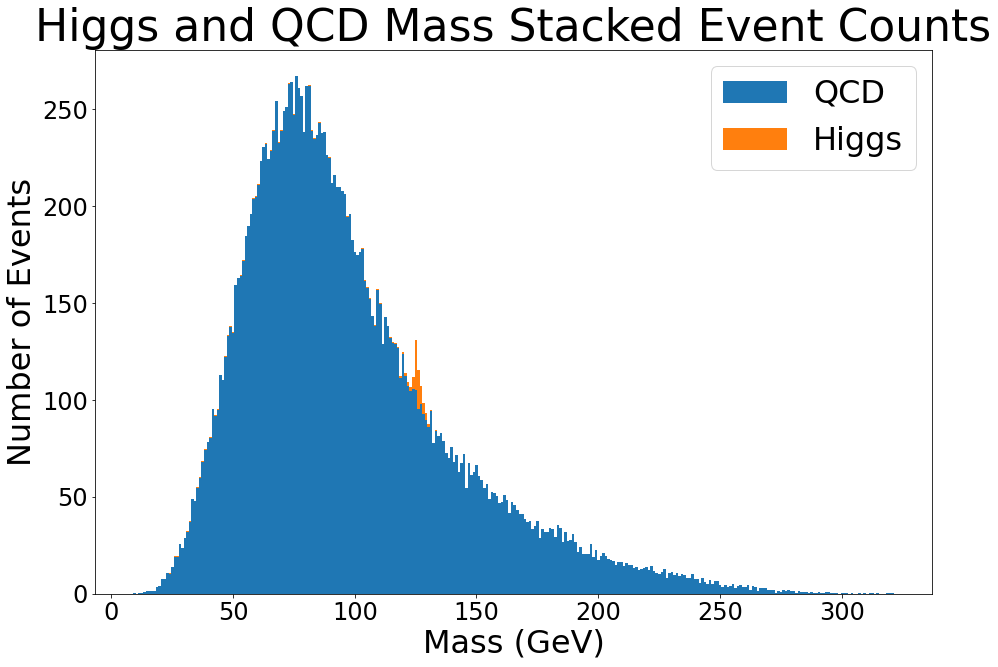

In [108]:
plt.rcParams["figure.figsize"] = (15,10)
plt.hist([qcd['mass'],higgs['mass']], histtype='bar',bins = 300, weights = [np.ones(100000)*2/10, np.ones(100000)/1000], stacked=True, label = ['QCD', 'Higgs'])
plt.legend(loc="upper right", fontsize = 32)
plt.xlabel('Mass (GeV)', fontsize = 32)
plt.ylabel('Number of Events', fontsize = 32)
plt.title('Higgs and QCD Mass Stacked Event Counts', fontsize = 44)
plt.tick_params(labelsize = 24)
plt.show()

The above graph is a stacked histogram of the QCD mass distribution and the Miggs measurement mass. Here we are adding the densities of the two instead of the raw number of events. It is important to note in this case ```qcd``` and ```higgs``` are the same size. This might not always be the case, and we would need to scale them to be the same size in order for this stacking to produce an accurate distribution. Here we do end up weighting our histograms, as a higgs event is a very rare event, and thus has a very small impact on the total distribution. All of this results in a new probability distribution for the Higgs particle in conjunction with the background. We can see our now very small characteristic peak around 125 GeV from the Higgs distribution, as well as a very large and much wider, peak around 75 GeV from our background distribution.

In [127]:
print('We calculate a significance of {} sigma, compared to our estimate of {}.'.format(
    str(-sp.norm.ppf(sp.poisson.sf(20100, mu=20000))), str(100 / np.sqrt(20000))
))

We calculate a significance of 0.7112259282313185 sigma, compared to our estimate of 0.7071067811865475.


In the above calculation, we compare our estimated significance to our calculated one. We see that they are very close. Our calculated significance starts by finding the probability of finding a signal of 20100 or more with a Poisson distribution with a mean of 20000. We take this probability use it to find the sigma value from a Gaussian with 0 mean and 1 stanard deviation. This gives us a value of roughly -0.711. Since the Gaussian is symmetric, we can invert this value to have roughly a significance value of 0.711. This is very comprable to our estimated significance of 0.707.

0.5190605131078458